# 1. Import Ntuple

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from termcolor import colored
import pandas as pd
import numpy as np
import uproot
from tqdm.auto import tqdm
tqdm.pandas()
import sys
sys.path.append('/home/belle/zhangboy/inclusive_R_D/')
import utilities as util
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.tab20.colors)

training_variables = util.training_variables
columns = util.all_relevant_variables #+ ['D_K_nCDCHits','D_pi1_nCDCHits','D_pi2_nCDCHits',
#                                         'D_K_pt','D_pi1_pt','D_pi2_pt',
#                                         'B0_deltaE','ell_p','B0_CMS_E','B0_CMS2_weMbc','B0_CMS0_weDeltae',
#                                         'B0_Lab5_weMissPTheta','B0_Lab6_weMissPTheta','B0_TagVReChi2']

In [ ]:
# 4S wrong charge Data vs MC

# Load data files
MC_wc = uproot.concatenate([f'../../Samples/Generic_MC15ri/e_channel/MC15ri_local_wrongCharge_200fb/*.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

data_wc = uproot.concatenate([f'../../Samples/Data/e_channel/WC/proc13_4S_wc_e_persian_3.root:B0'],
                          library="np",
                          #cut = '(D_M>1.855) & (D_M<1.885)',
                          filter_branch=lambda branch: branch.name in columns)

df_mc = pd.DataFrame(MC_wc)
df_data = pd.DataFrame(data_wc)

BDT_combinatorial='signal_prob<0.3 and fakeB_prob>0.8 and fakeD_prob<0.05'
BDT_sig='signal_prob==largest_prob and signal_prob>0.8 and fakeB_prob<0.04 and fakeD_prob<0.05'
BDT_no_sig = 'signal_prob<0.3'

In [ ]:
for df in [df_mc,df_data,]:
    # df.eval(f'cos_D_l = (D_px*ell_px + D_py*ell_py + D_pz*ell_pz)/(D_p*ell_p)', inplace=True)
    df.eval('B_D_ReChi2 = B0_vtxReChi2 + D_vtxReChi2', inplace=True)
    df.eval(f'p_D_l = D_CMS_p + ell_CMS_p', inplace=True)

In [ ]:
# load MVA
import lightgbm as lgb
df_mc_BDT_combi = util.apply_mva_bcs(df_mc, training_variables, BDT_combinatorial)
df_data_BDT_combi = util.apply_mva_bcs(df_data, training_variables, BDT_combinatorial)

df_mc_BDT_sig = util.apply_mva_bcs(df_mc, training_variables, BDT_sig)
df_data_BDT_sig = util.apply_mva_bcs(df_data, training_variables, BDT_sig)

df_mc_BDT_no_sig = util.apply_mva_bcs(df_mc, training_variables, BDT_no_sig)
df_data_BDT_no_sig = util.apply_mva_bcs(df_data, training_variables, BDT_no_sig)

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


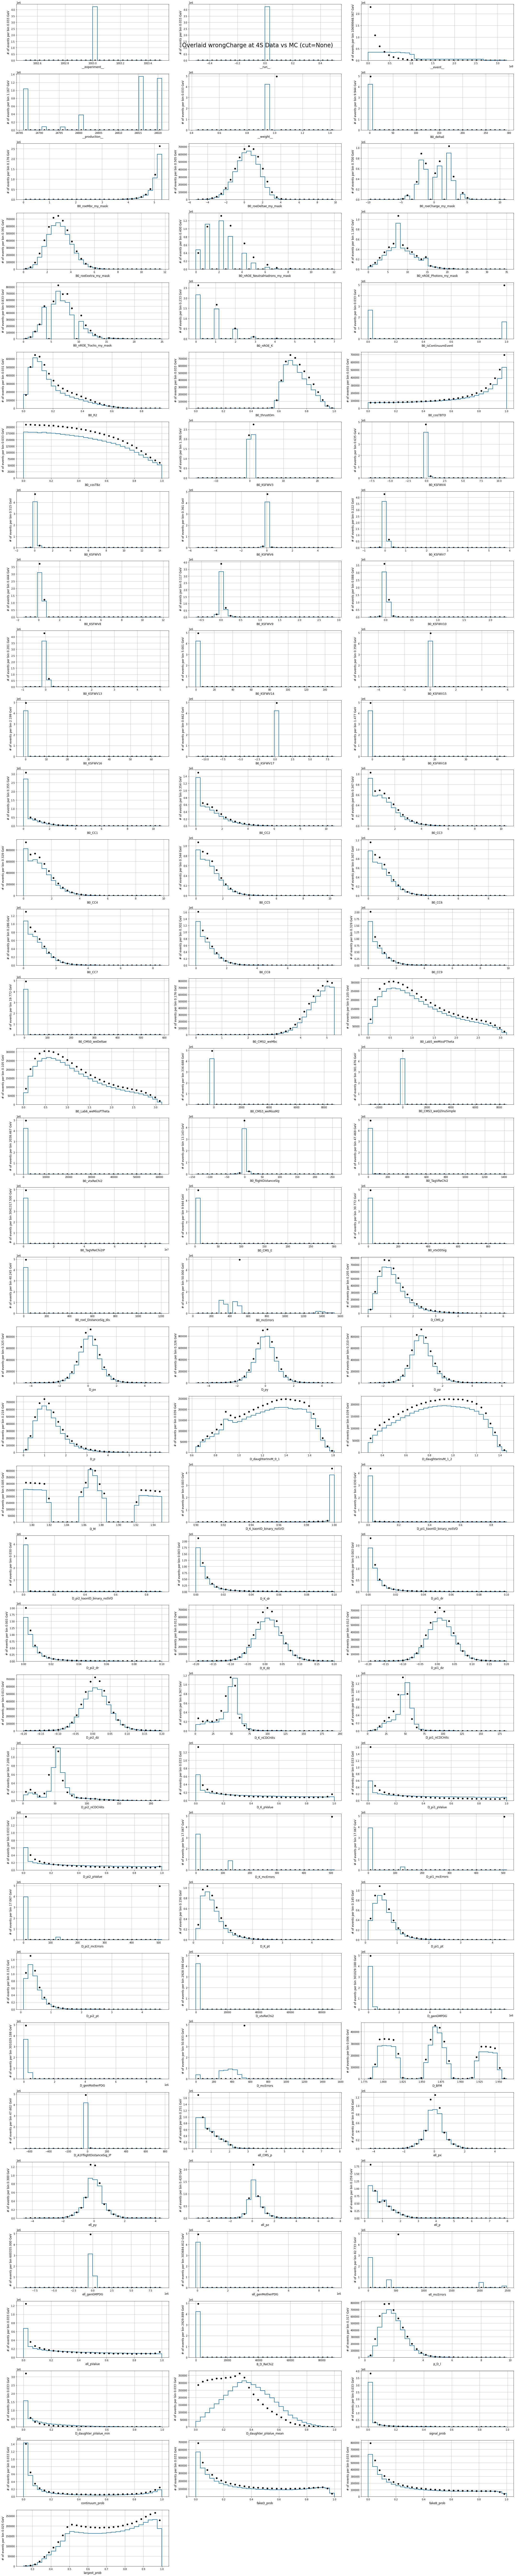

In [14]:
plot_data_mc(data=df_bestSelected_data, mc=df_bestSelected_mc, 
             bins=30,variables=columns_without_nan,cut=None,scale=[1.86/2,1],
            figsize=(30, 150), fontsize=12)

## Data vs. MC fake D shape

In [5]:
columns_without_nan = df_data_BDT_no_sig.columns[~df_data_BDT_no_sig.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_mc_BDT_no_sig, 'e', template=False)
mpl=util.mpl(samples,df_data_BDT_no_sig)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

bkg_FakeD 4363489
bkg_TDFl 52447
bkg_fakeTracks 156858
bkg_continuum 46527
bkg_combinatorial 219541
bkg_singleBbkg 12866
bkg_other_TDTl 0
$D\tau\nu$ 0
$D^\ast\tau\nu$ 0
$D\ell\nu$ 0
$D^\ast\ell\nu$ 0
$D^{\ast\ast}\tau\nu$ 0
$D^{\ast\ast}\ell\nu$ 0
$D\ell\nu$_gap 0
bkg_other_signal 0


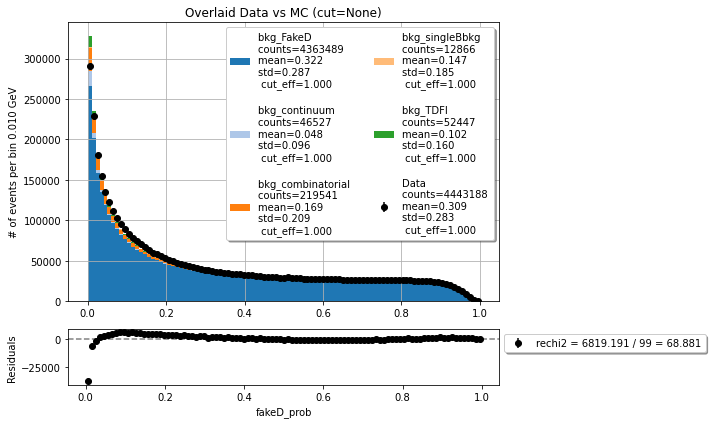

In [7]:
b1 = np.linspace(0,1,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='fakeD_prob',bins=b1,
                                                      cut=None,scale=[1,187/200],
                                                      correction=False,mask=[],
                                                      figsize=(10,6),ratio=False)

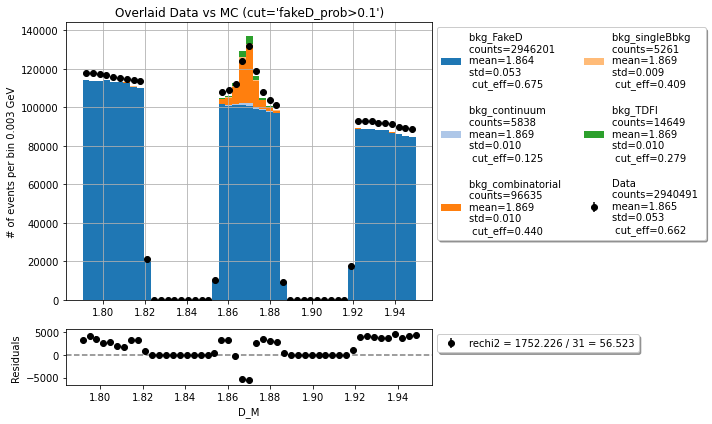

In [9]:
b1 = np.linspace(1.79,1.95,50)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(variable='D_M',bins=b1,
                                                      cut='fakeD_prob>0.1',scale=[1,187/200],
                                                      correction=False,mask=[],
                                                      figsize=(10,6),ratio=False)

## consistent discrepency, sidebands vs. sig region

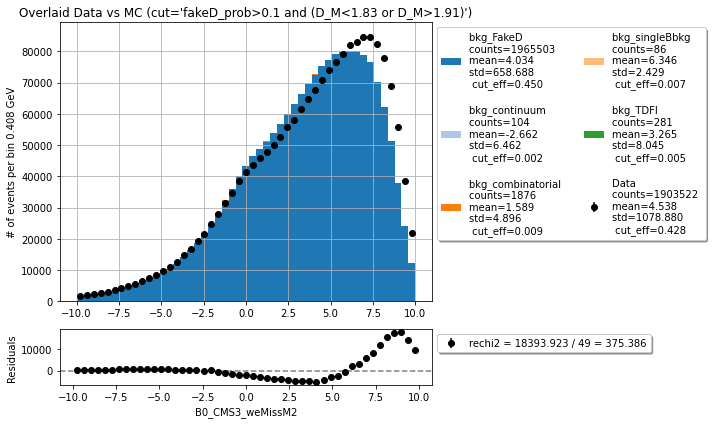

In [14]:
# sidebands
b1 = np.linspace(-10,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,ratio=False,
                          cut='fakeD_prob>0.1 and (D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6))

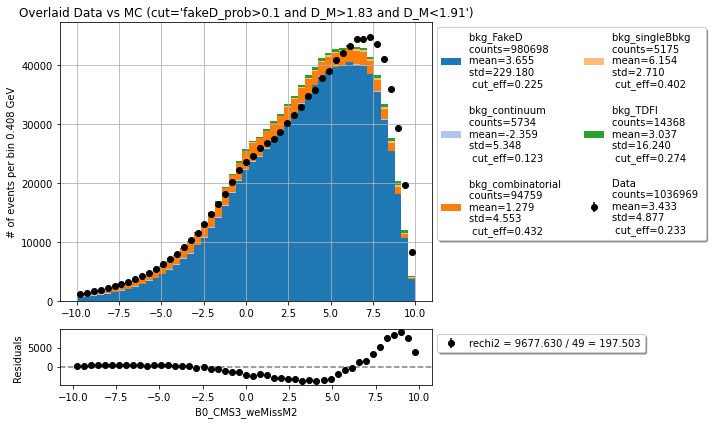

In [15]:
# signal
b1 = np.linspace(-10,10,50)
a,b=mpl.plot_data_mc_stacked(variable='B0_CMS3_weMissM2',bins=b1,ratio=False,
                          cut='fakeD_prob>0.1 and D_M>1.83 and D_M<1.91',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6))

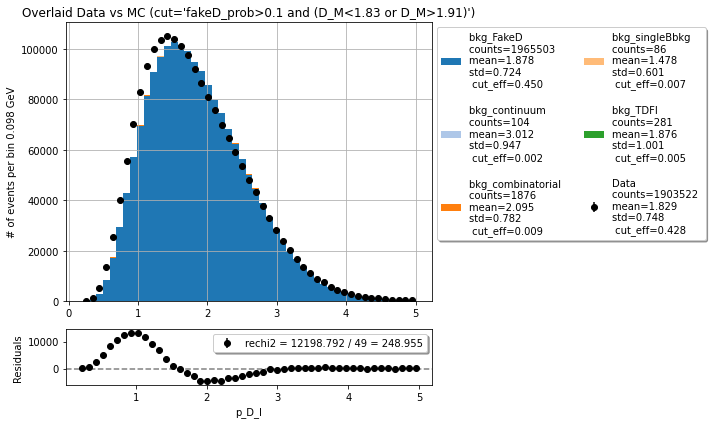

In [16]:
# sidebands
b2 = np.linspace(0.2,5,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='fakeD_prob>0.1 and (D_M<1.83 or D_M>1.91)',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6))

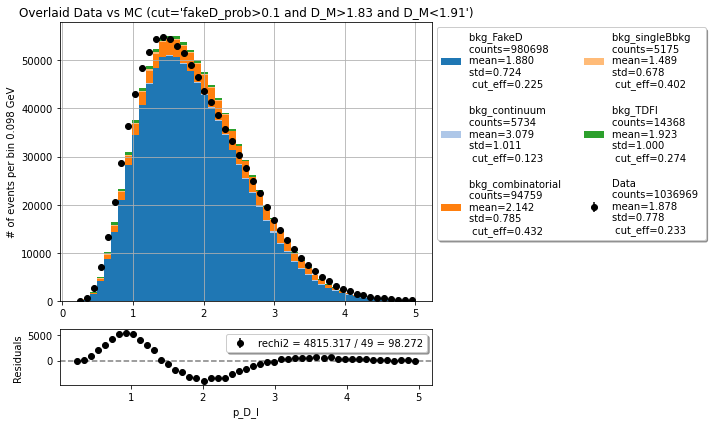

In [17]:
# signal
b2 = np.linspace(0.2,5,50)
a,b=mpl.plot_data_mc_stacked(variable='p_D_l',bins=b2,ratio=False,
                          cut='fakeD_prob>0.1 and D_M>1.83 and D_M<1.91',
                          scale=[1,187/200],correction=False,mask=[],figsize=(10,6))

# Create data driven template for combinatorial
## 1. Calculate the sidebands to sig region scaling factors

In [ ]:
columns_without_nan = df_data_BDT_combi.columns[~df_data_BDT_combi.isna().any()].tolist()

samples=util.get_dataframe_samples_new(df_mc_BDT_combi, 'e', template=False)
mpl=util.mpl(samples,df_data_BDT_combi)
# df_conti_conti = samples['bkg_continuum']
for name, df in samples.items():
    print(name, len(df))

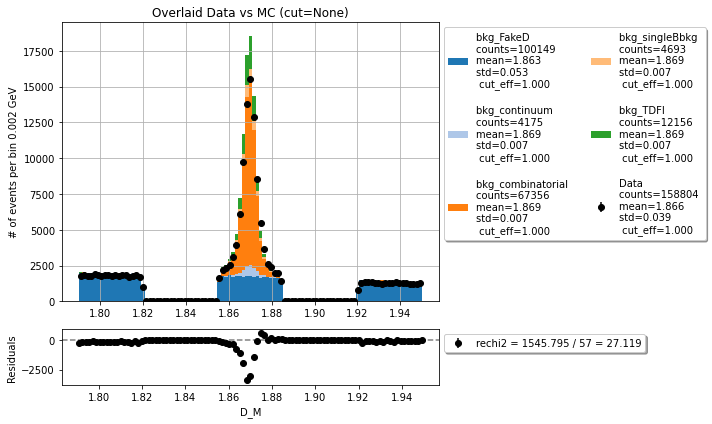

In [20]:
# showing the fake D and sidebands in D_M
b1 = np.linspace(1.79,1.95,100)
data_hist_all, mc_hist_all = mpl.plot_data_mc_stacked(
    variable='D_M',bins=b1,cut=None,scale=[1,187/200],
    correction=False,mask=[],figsize=(10,6),ratio=False)

In [ ]:
fitter = util.fit_iminuit(x_edges=b1, hist=mc_hist_all)

In [ ]:
m_ls, c_ls, result_ls = fitter.fit_gauss_poly_LS(deg=1, loss='linear') #'soft_l1'
m_ls

In [ ]:
m_ml, c_ml, result_ml = fitter.fit_gauss_poly_ML(deg=1)
m_ml

In [ ]:
area_left,error_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ls)
area_sig, error_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ls)
area_right,error_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ls)
yields_left = fitter.poly_integral(xrange=[1.79,1.82],result=result_ml)
yields_sig = fitter.poly_integral(xrange=[1.855,1.885],result=result_ml)
yields_right = fitter.poly_integral(xrange=[1.92,1.95],result=result_ml)

In [ ]:
a = len(samples['bkg_FakeD'].query('1.79<D_M<1.82')) * 187/200
b = len(samples['bkg_FakeD'].query('1.92<D_M<1.95')) * 187/200
print('truth',a,b, a/b)

In [ ]:
# calculating the scaling factors from mc
b1 = np.linspace(-10,10,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=False,
                        scale=scale,correction=False,mask=[])

In [ ]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,5,50)
scale = {'left sideband': yields_sig/yields_left/2,
         'signal region': 1,
         'right sideband': yields_sig/yields_right/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut=None,
                        scale=scale,correction=False,mask=[])

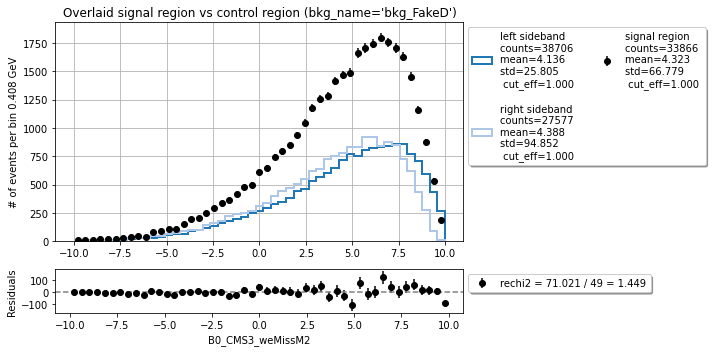

In [41]:
# calculating the scaling factors from mc
b1 = np.linspace(-10,10,50)
scale = {'left sideband': 338/387/2,
         'signal region': 1,
         'right sideband': 338/275/2}
mpl.plot_mc_sig_control(variable='B0_CMS3_weMissM2',bins=b1,
                        bkg_name='bkg_FakeD',cut=None,merge_sidebands=False,
                        scale=scale,correction=False,mask=[],figsize=(10,5))

In [ ]:
# subtract the scaled sidebands in the signal region
b_mm2 = np.linspace(-10,10,50)
b_pDl = np.linspace(0.2,5,50)
scale = {'data left sideband': yields_sig/yields_left/2,
         'data signal region': 1,
         'data right sideband': yields_sig/yields_right/2,
         'mc signal region': 187/200}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': False,
          'mask': ['bkg_FakeD']}
mpl.plot_data_subtracted_and_mc(**par_dict)

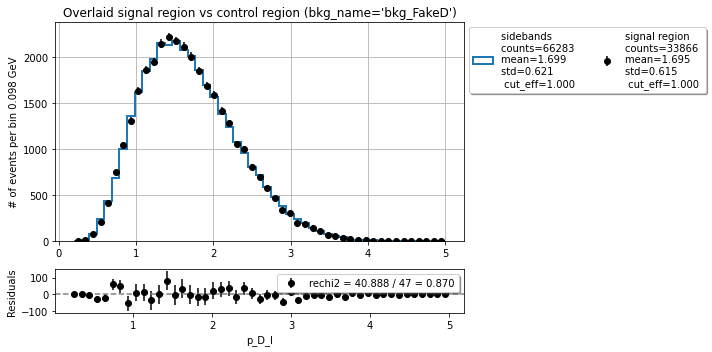

In [42]:
# showing the scaled sidebands vs. sig region from mc
b2 = np.linspace(0.2,5,50)
scale = {'left sideband': 338/387/2,
         'signal region': 1,
         'right sideband': 338/275/2}
mpl.plot_mc_sig_control(variable='p_D_l',bins=b2,merge_sidebands=True,
                        bkg_name='bkg_FakeD',cut=None,
                        scale=scale,correction=False,mask=[],figsize=(10,5))

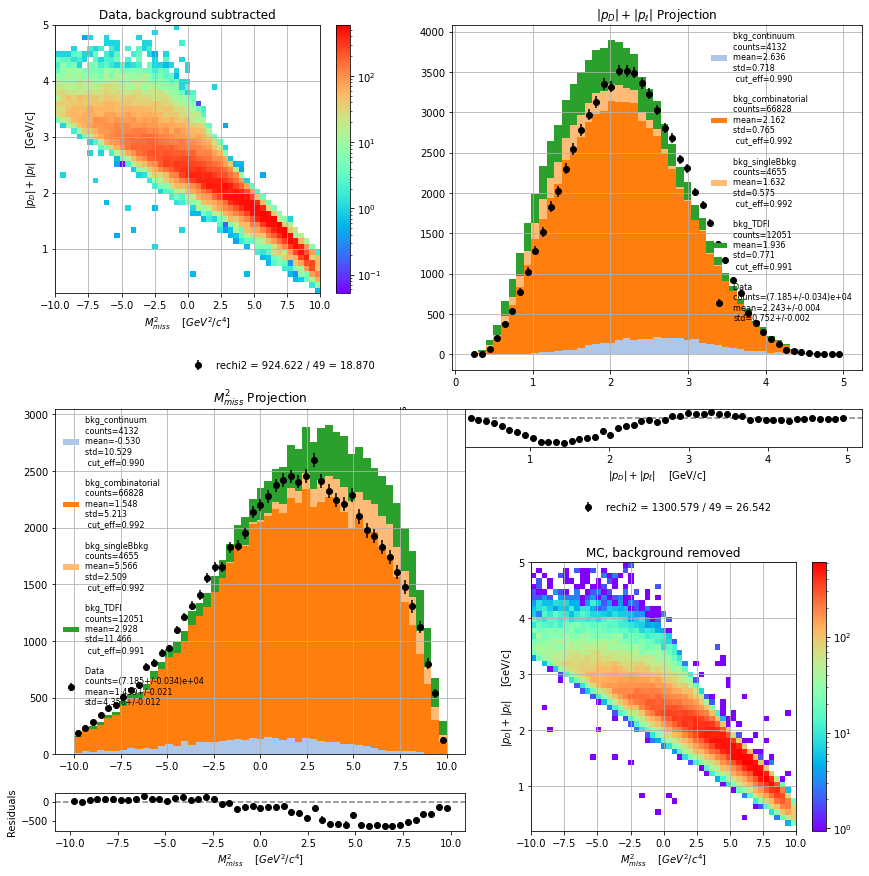

In [6]:
# subtract the scaled sidebands in the signal region
b_mm2 = np.linspace(-10,10,50)
b_pDl = np.linspace(0.2,5,50)
scale = {'data left sideband': 338/387/2,
         'data signal region': 1,
         'data right sideband': 338/275/2,
         'mc signal region': 187/200}
par_dict={'var_list':['B0_CMS3_weMissM2','p_D_l'],
          'bin_list': [b_mm2, b_pDl],
          'cut': None,
          'scale': scale,
          'correction': False,
          'mask': ['bkg_FakeD'],
          'figsize':(14,14)}
mpl.plot_data_subtracted_and_mc(**par_dict)

## Lepton Correction

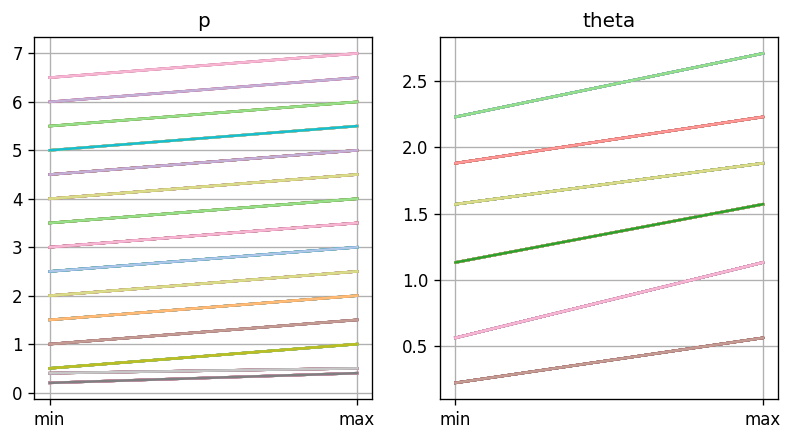

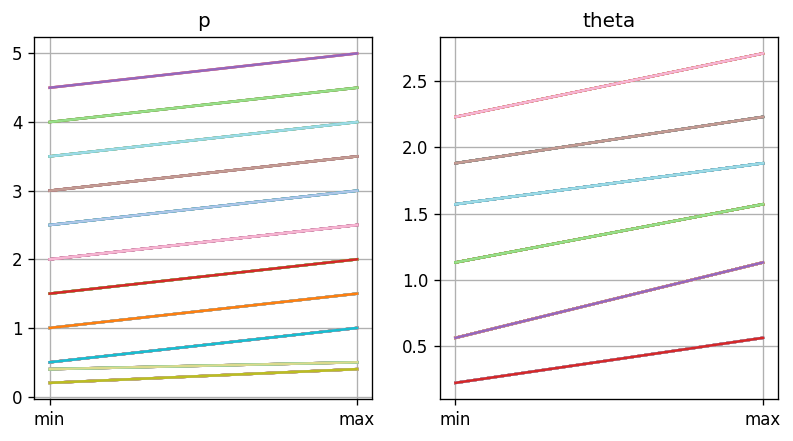

In [13]:
efficiency_e_table = pd.read_csv('~/B2SW/2024_OleMiss/systematics_framework/correction-tables/MC15/run_independent/PID/coarse_theta_binning/efficiency/e_efficiency_table.csv')
pi_e_fake_table = pd.read_csv('~/B2SW/2024_OleMiss/systematics_framework/correction-tables/MC15/run_independent/PID/coarse_theta_binning/fakeRate/pi_e_fakeRate_table.csv')

final_query = 'is_best_available == True'
final_query += ' and variable == "pidChargedBDTScore_e"'
final_query += ' and threshold == 0.9'
efficiency_e_table = efficiency_e_table.query(final_query)
pi_e_fake_table = pi_e_fake_table.query(final_query)

exclude_e_bins_query = "not (p_min == 0.2 and p_max == 5.0) "
exclude_e_bins_query += "and not (theta_min == 0.22 and theta_max == 2.71) "
exclude_e_bins_query += "and not (theta_min == 0.56 and theta_max == 2.23)"

efficiency_e_table = efficiency_e_table.query(exclude_e_bins_query)
pi_e_fake_table = pi_e_fake_table.query(exclude_e_bins_query)

fig, axs = plt.subplots(1,2, figsize=(8, 4), dpi=120)
axs[0].plot(efficiency_e_table[['p_min', 'p_max']].values.T);
axs[1].plot(efficiency_e_table[['theta_min', 'theta_max']].values.T);
axs[0].set_xticks([0,1], ['min', 'max'])
axs[1].set_xticks([0,1], ['min', 'max'])
axs[0].set_title('p')
axs[1].set_title('theta')
axs[0].grid()
axs[1].grid();

fig, axs = plt.subplots(1,2, figsize=(8, 4), dpi=120)
axs[0].plot(pi_e_fake_table[['p_min', 'p_max']].values.T);
axs[1].plot(pi_e_fake_table[['theta_min', 'theta_max']].values.T);
axs[0].set_xticks([0,1], ['min', 'max'])
axs[1].set_xticks([0,1], ['min', 'max'])
axs[0].set_title('p')
axs[1].set_title('theta')
axs[0].grid()
axs[1].grid();

## Hadron Correction

In [14]:
efficiency_K_table = pd.read_csv('tables/k_efficiency.csv', index_col=None)
pi_K_fake_table = pd.read_csv('tables/pi_K_fake.csv', index_col=None)

## Apply corrections

In [15]:
import warnings
from sysvar import add_weights_to_dataframe

e_tables = {(11, 11): efficiency_e_table,
            (11, 211): pi_e_fake_table
}
e_thresholds = {11: ('pidChargedBDTScore_e', 0.9)}

df_bestSelected_mc = df_bestSelected_mc.reset_index() # for a bug in add_weights_to_dataframe

Welcome to JupyROOT 6.26/14


Required variables: ['ell_p', 'ell_charge', 'ell_theta', 'ell_PDG', 'ell_mcPDG']
Coverage:
PID ell: 90.0%


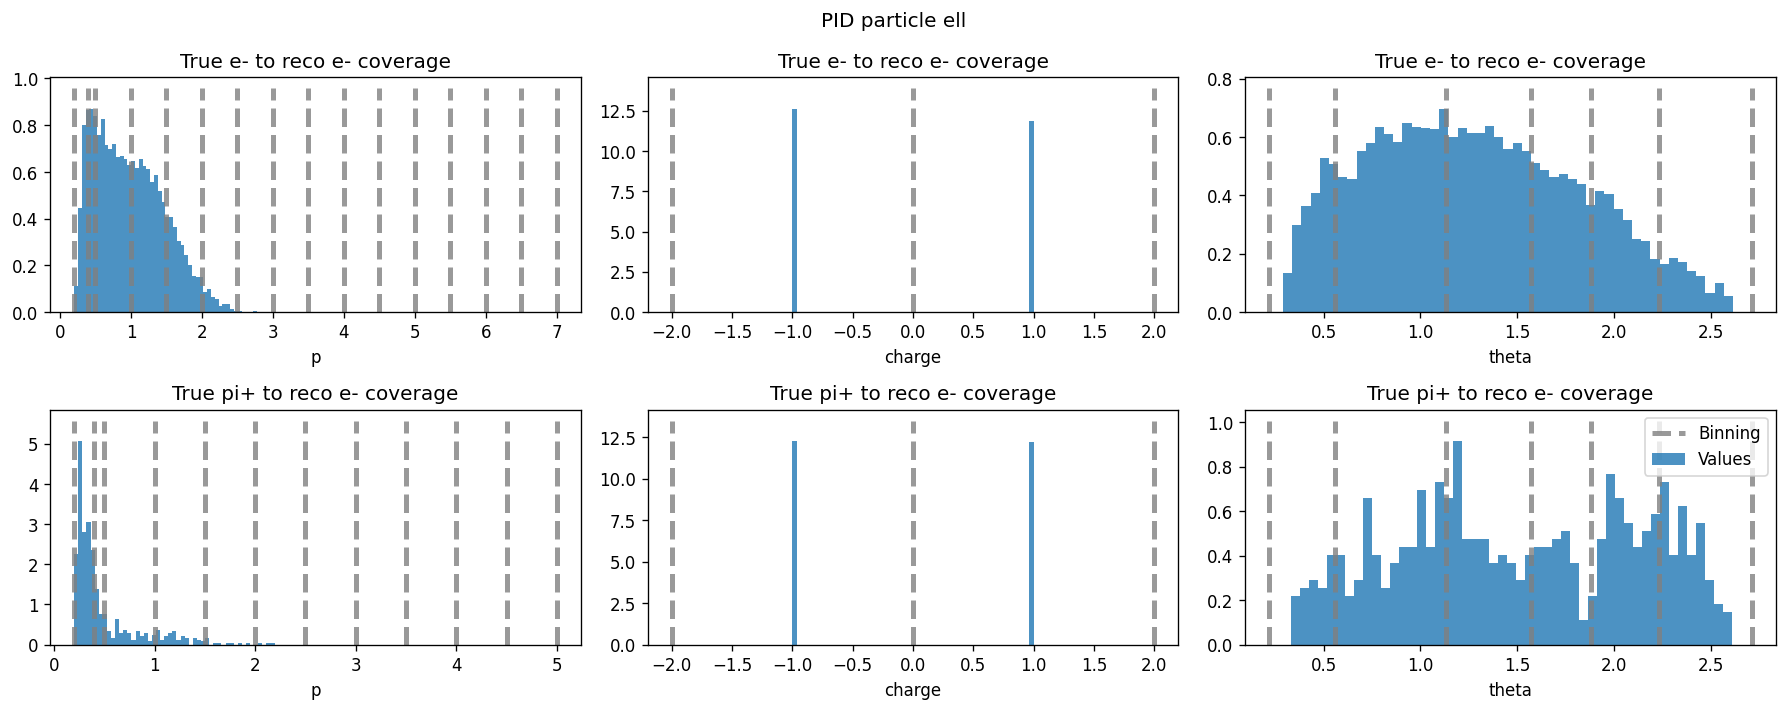

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    add_weights_to_dataframe('ell',
                             df_bestSelected_mc,
                             systematic='custom_PID',
                             custom_tables=e_tables,
                             custom_thresholds=e_thresholds,
                             show_plots=True,
                             sys_seed=0)

Required variables: ['D_K_cosTheta', 'D_K_p', 'D_K_charge', 'D_K_PDG', 'D_K_mcPDG']
Coverage:
PID D_K: 90.5%


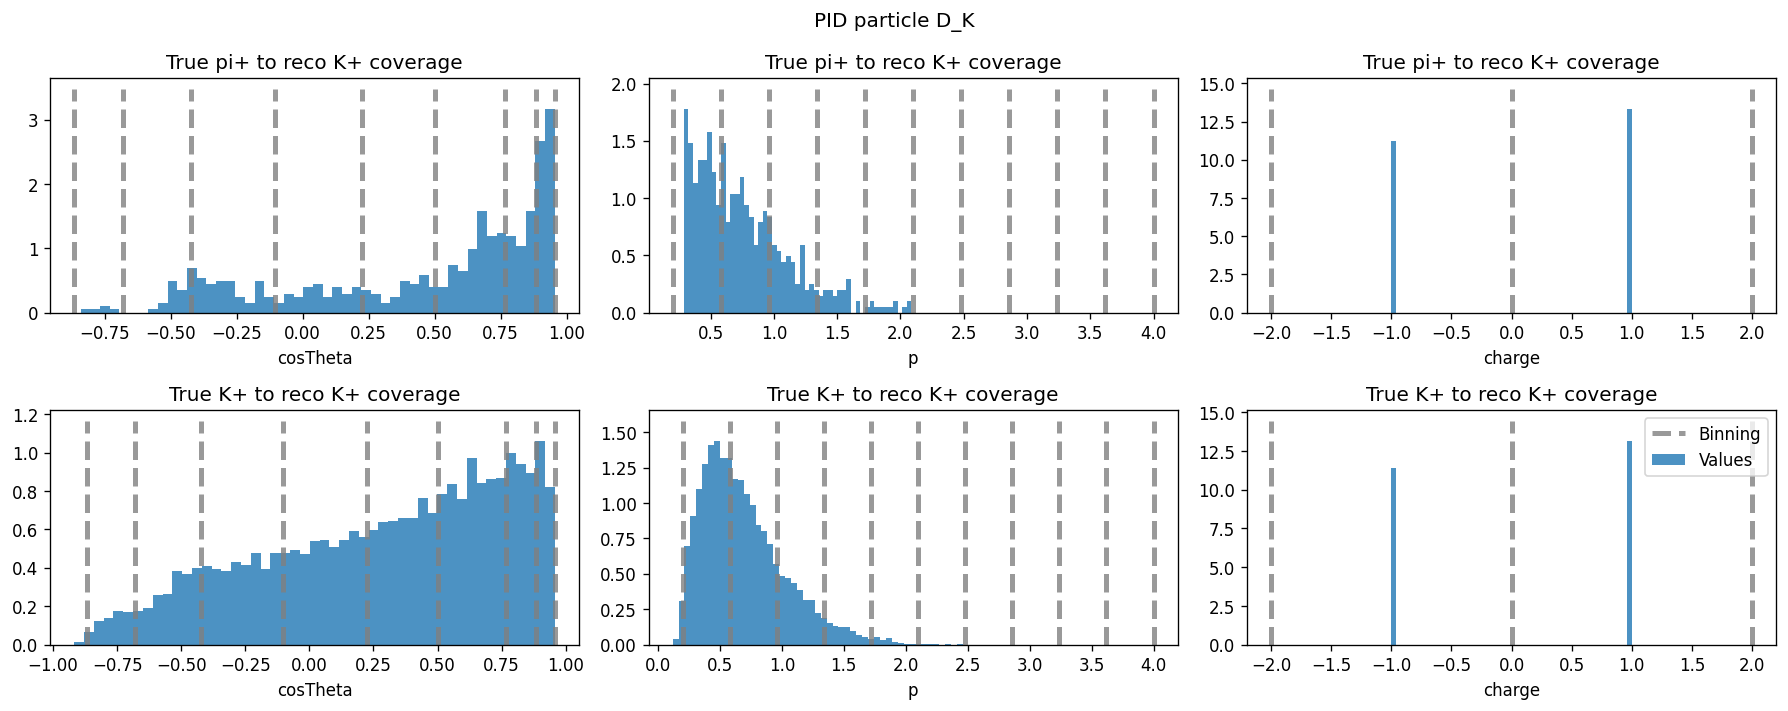

In [17]:
k_tables = {(321, 321): efficiency_K_table,
            (321, 211): pi_K_fake_table}
k_thresholds = {321: ('kaonID', 0.9)}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    add_weights_to_dataframe('D_K',
                             df_bestSelected_mc,
                             systematic='custom_PID',
                             custom_tables=k_tables,
                             custom_thresholds=k_thresholds,
                             show_plots=True)

In [18]:
df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc[['ell_Weight', 'D_K_Weight']].product(axis=1)

/tmp/ipykernel_83976/85433479.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_bestSelected_mc['PIDWeight'] = df_bestSelected_mc[['ell_Weight', 'D_K_Weight']].product(axis=1)


In [19]:
samples=util.get_dataframe_samples_new(df_bestSelected_mc, 'e', template=False)
mpl=util.mpl(samples,df_bestSelected_data)

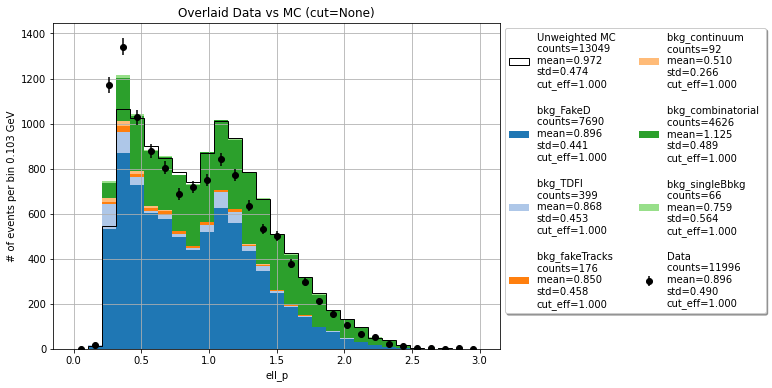

In [22]:
b1 = np.linspace(0,3,30)
mpl.plot_data_mc_overlaid(variable='ell_p',bins=b1,cut=None,scale=[1, 1.87/2],correction=True)

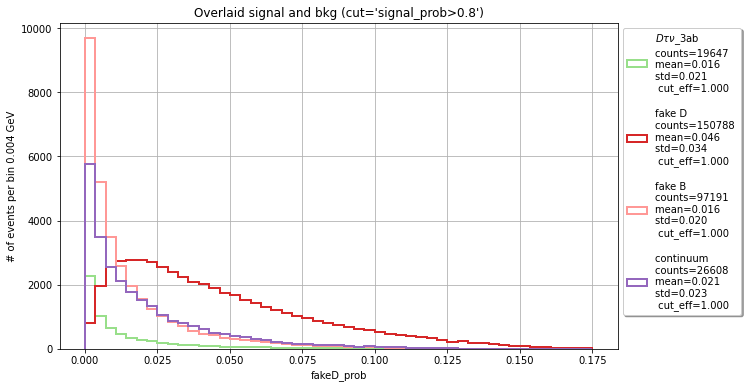

In [9]:
b1 = np.linspace(0,0.175,50)
plot_bkg_overlaid(variable='fakeD_prob',bins=b1,scale=[1/3,1/3,1/3,1],cut='signal_prob>0.8')

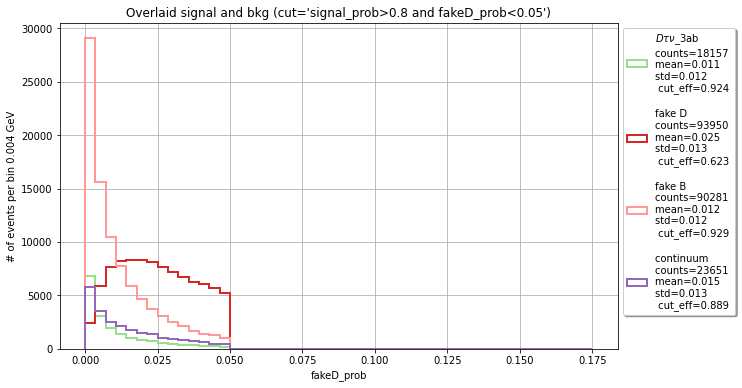

In [45]:
b1 = np.linspace(0,0.175,50)
plot_bkg_overlaid(variable='fakeD_prob',bins=b1,scale=[1,1,1,1],cut='signal_prob>0.8 and fakeD_prob<0.05')

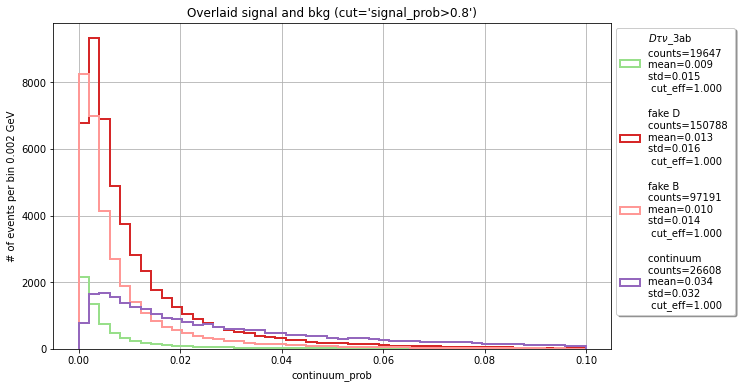

In [12]:
b1 = np.linspace(0,0.1,50)
plot_bkg_overlaid(variable='continuum_prob',bins=b1,scale=[1/3,1/3,1/3,1],cut='signal_prob>0.8')

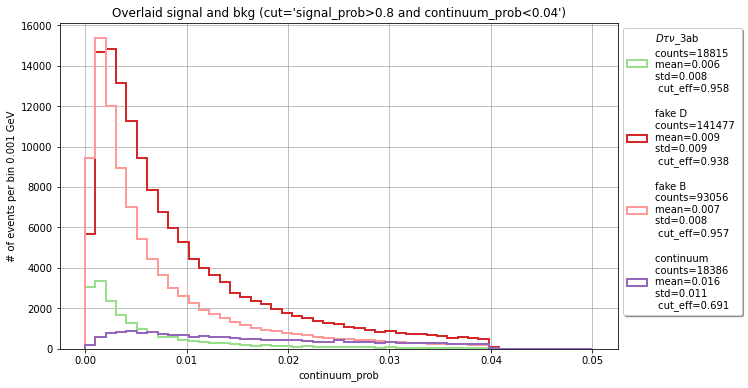

In [31]:
b1 = np.linspace(0,0.05,50)
plot_bkg_overlaid(variable='continuum_prob',bins=b1,scale=[1,1,1,1],cut='signal_prob>0.8 and continuum_prob<0.04')

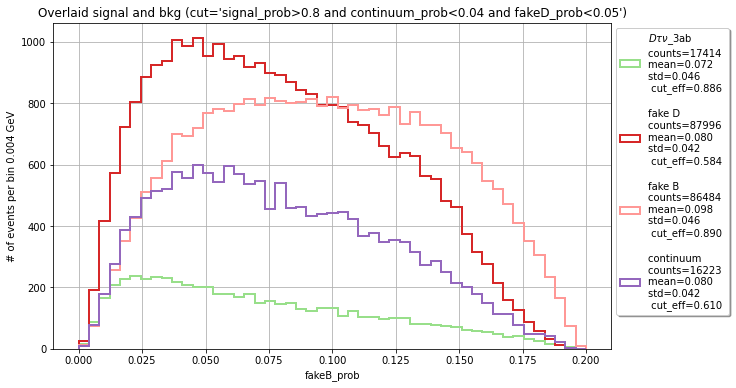

In [16]:
b1 = np.linspace(0,0.2,50)
plot_bkg_overlaid(variable='fakeB_prob',bins=b1,scale=[1/3,1/3,1/3,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05')

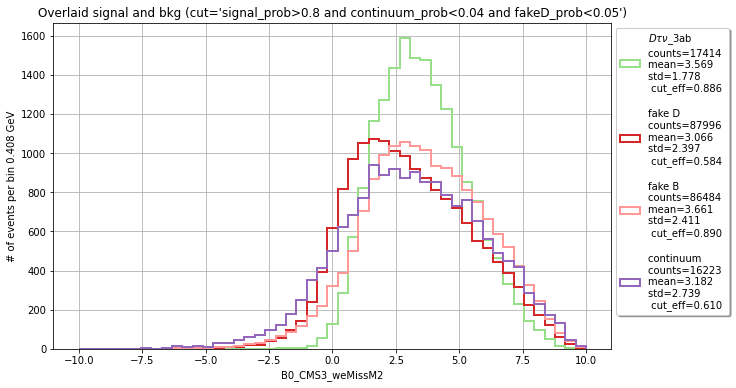

In [30]:
b1 = np.linspace(-10,10,50)
plot_bkg_overlaid(variable='B0_CMS3_weMissM2',bins=b1,scale=[1,16/87,16/86,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05')

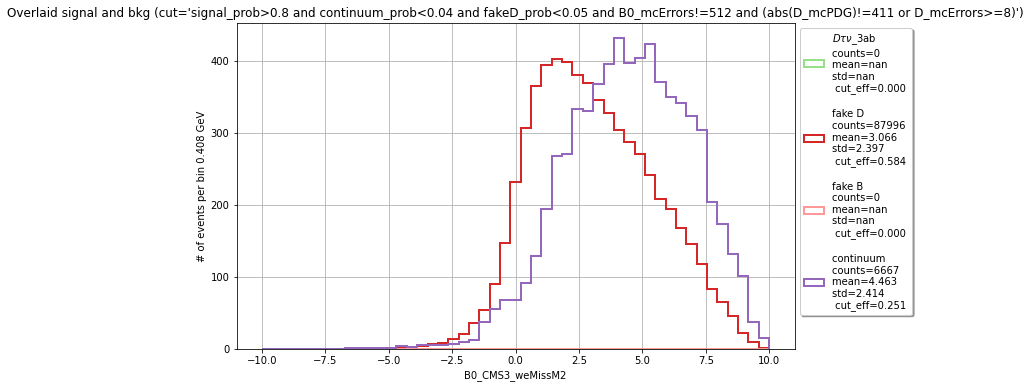

In [25]:
b1 = np.linspace(-10,10,50)
plot_bkg_overlaid(variable='B0_CMS3_weMissM2',bins=b1,scale=[1,6/87,1,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05 and B0_mcErrors!=512 and (abs(D_mcPDG)!=411 or D_mcErrors>=8)')

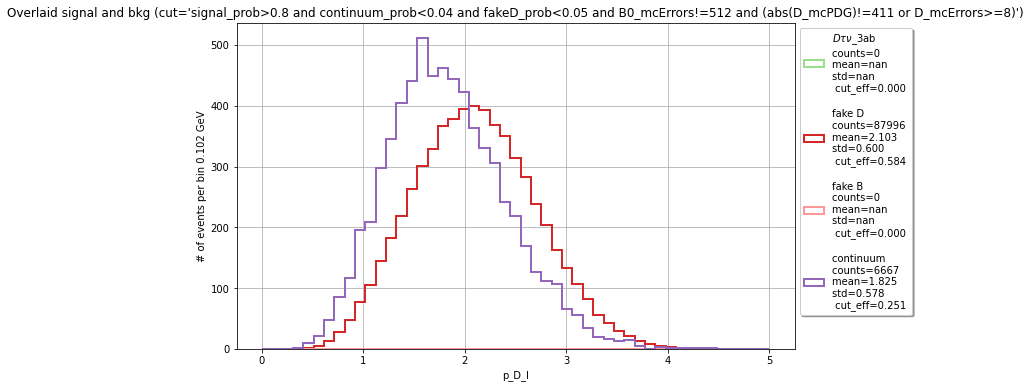

In [36]:
b1 = np.linspace(0,5,50)
plot_bkg_overlaid(variable='p_D_l',bins=b1,scale=[1,6/87,1,1],cut='signal_prob>0.8 and continuum_prob<0.04 and fakeD_prob<0.05 and B0_mcErrors!=512 and (abs(D_mcPDG)!=411 or D_mcErrors>=8)')

In [18]:
# Assuming your DataFrame is named 'df'
# Use dtypes attribute to get the data types of each column
column_data_types = samples[r'$D\tau\nu$'].dtypes

# Filter the columns that have data type 'object' (strings)
columns_with_strings = column_data_types[column_data_types == 'object'].index.tolist()

# Now, columns_with_strings contains the names of columns with strings
print("Columns with strings:", columns_with_strings)


Columns with strings: []


In [8]:
# Check for duplicate entries
util.check_duplicate_entries(samples)

No duplicate pairs found.
